### Object Detection via Semantic Segmentation

#### Import Modules

In [1]:
# IMPORT MODULES
# Import Import Numpy, TensorFlow, Scipy, Keras
import sys
import time
import os
import numpy as np 
import pandas as pd 
from glob import glob
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import pickle
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
import random
from sklearn.utils import shuffle
import csv
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tensorflow.examples.tutorials.mnist import input_data
import keras
from keras.datasets import cifar10
from keras.models import Sequential,model_from_json
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Convolution2D,MaxPooling2D
from keras.layers import Flatten,Lambda,ELU
from keras.optimizers import SGD,Adam,RMSprop
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import glorot_uniform
from sklearn.cross_validation import train_test_split
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import SVG
import json
from keras.models import Sequential, model_from_json
print('Import Modules')

Import Modules


Using TensorFlow backend.


#### Load Data

In [2]:
# LOAD DATA
# Change Directory
os.chdir('..')

In [3]:
# LOAD DATA
# Find Files
all_paths = pd.DataFrame(dict(Path = glob(os.path.join('Data','*', '*.*p*g'))))
all_paths['Split'] = all_paths['Path'].map(lambda x: x.split('/')[-2].split('-')[0])
all_paths['Group'] = all_paths['Path'].map(lambda x: x.split('/')[-2].split('-')[-1])
all_paths['ID'] = all_paths['Path'].map(lambda x: '_'.join(os.path.splitext(os.path.basename(x))[0].split('_')[:4]))

In [4]:
# LOAD DATA
# Display Samples
all_paths.sample(5)

Path  Split  Group  \
54504  Data/Train-Label/170908_072820973_Camera_6_ins...  Train  Label   
57957  Data/Train-Label/170927_070435552_Camera_6_ins...  Train  Label   
13585     Data/Train-Color/170908_075340591_Camera_6.jpg  Train  Color   
58010  Data/Train-Label/170908_075423203_Camera_5_ins...  Train  Label   
51822  Data/Train-Label/170908_065012481_Camera_5_ins...  Train  Label   

                              ID  
54504  170908_072820973_Camera_6  
57957  170927_070435552_Camera_6  
13585  170908_075340591_Camera_6  
58010  170908_075423203_Camera_5  
51822  170908_065012481_Camera_5

In [5]:
# LOAD DATA
# Pivot Data
group_df = all_paths.pivot_table(values = 'Path', columns = 'Group', \
                                 aggfunc = 'first', index = ['ID', 'Split']).reset_index()

In [6]:
# LOAD DATA
# Display Samples
group_df.sample(5)

Group                         ID  Split  \
26545  171206_025859115_Camera_5  Train   
32877  171206_033000126_Camera_5  Train   
38570  171206_034419463_Camera_5  Train   
25461  170927_070423029_Camera_6  Train   
35245  171206_033609954_Camera_6  Train   

Group                                           Color  \
26545  Data/Train-Color/171206_025859115_Camera_5.jpg   
32877  Data/Train-Color/171206_033000126_Camera_5.jpg   
38570  Data/Train-Color/171206_034419463_Camera_5.jpg   
25461  Data/Train-Color/170927_070423029_Camera_6.jpg   
35245  Data/Train-Color/171206_033609954_Camera_6.jpg   

Group                                              Label  
26545  Data/Train-Label/171206_025859115_Camera_5_ins...  
32877  Data/Train-Label/171206_033000126_Camera_5_ins...  
38570  Data/Train-Label/171206_034419463_Camera_5_ins...  
25461  Data/Train-Label/170927_070423029_Camera_6_ins...  
35245  Data/Train-Label/171206_033609954_Camera_6_ins...

In [7]:
# LOAD DATA
# Load Training Data Files
training_data_files = group_df.query('Split=="Train"')
data_size = training_data_files.shape[0]
print('Size of Training Data', data_size)

Size of Training Data 39222


#### Explore Data

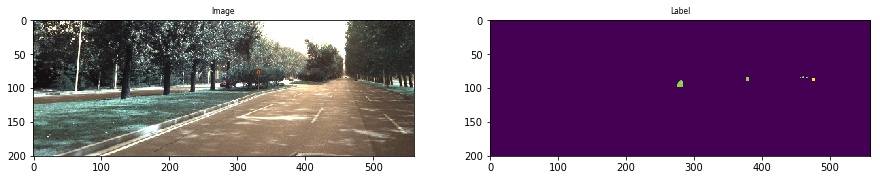

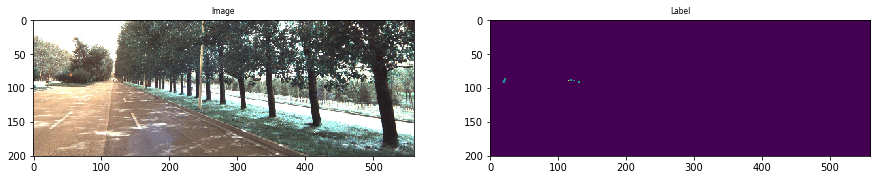

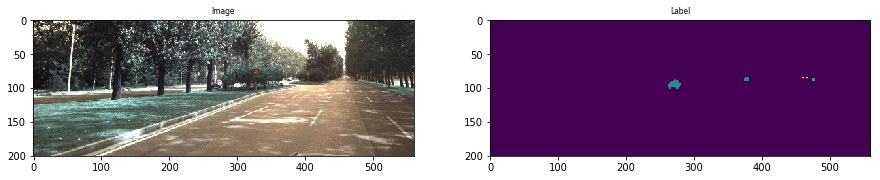

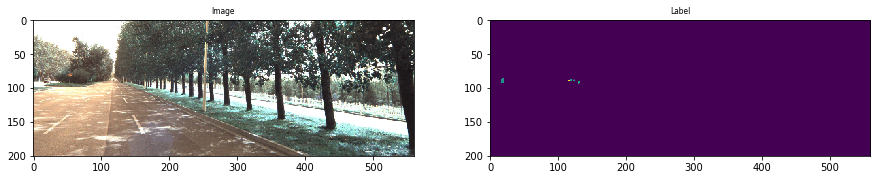

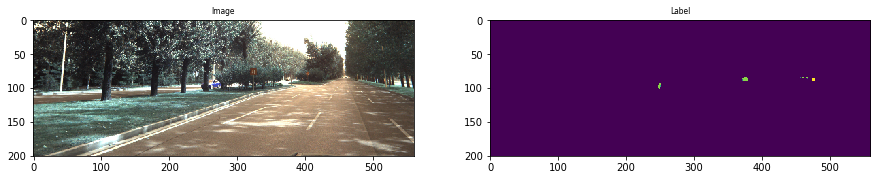

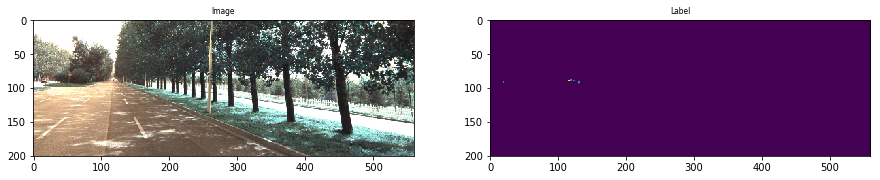

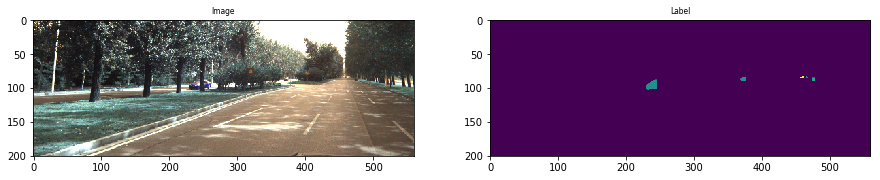

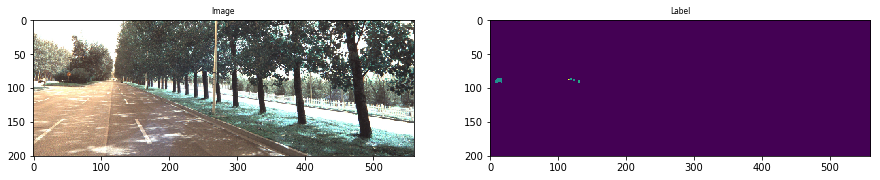

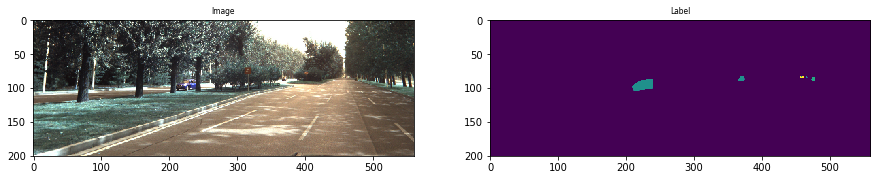

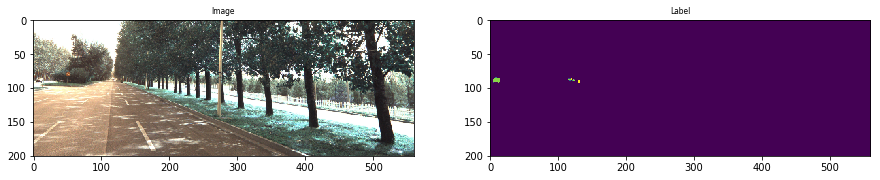

In [8]:
# EXPLORE DATA
# Load Images in Loop and Display
for i in range(1020,1030):
    # Load Images
    input_img = cv2.imread(training_data_files['Color'][i])
    label_img = cv2.imread(training_data_files['Label'][i])
    
    # Crop
    input_img = input_img[1200:2400,:]
    label_img = label_img[1200:2400,:]
    
    # Convert to Grayscale
    label_img = cv2.cvtColor(label_img, cv2.COLOR_RGB2GRAY)
    
    # Resize Image to 100x100
    input_img = cv2.resize(input_img, (560, 200))
    label_img = cv2.resize(label_img, (560, 200))
    
    # Plot
    fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,15))
    axis1.imshow(input_img)
    axis1.set_title('Image',fontsize=7.5)
    axis2.imshow(label_img)
    axis2.set_title('Label',fontsize=7.5)

#### Preprocess Data

In [9]:
# PREPROCESS DATA
# Clear Memory
del all_paths
del group_df

In [10]:
# PREPROCESS DATA
# Load Input Images
x_train = []
for i in range(10000):
    # Load Images
    input_img = cv2.imread(training_data_files['Color'][i])
    
    # Crop
    input_img = input_img[1200:2400,:]
    
    # Resize Image to 100x280
    input_img = cv2.resize(input_img, (288, 288))
    
    # Flatten Image and Append 
    image_flat = input_img.flatten().tolist()
    x_train += image_flat
    
    # Check Progress
    if (i%100 == 0):
        print('Images Loaded:', i)

# Check Size of Data
image_feature_size=int(len(x_train))
print("Feature Size:", image_feature_size)

# Revert to the Original Image Shapes
x_train = np.array(x_train).reshape(10000, 288, 288, 3)
print("Feature Size:", x_train.shape)

Images Loaded: 0
Images Loaded: 100
Images Loaded: 200
Images Loaded: 300
Images Loaded: 400
Images Loaded: 500
Images Loaded: 600
Images Loaded: 700
Images Loaded: 800
Images Loaded: 900
Images Loaded: 1000
Images Loaded: 1100
Images Loaded: 1200
Images Loaded: 1300
Images Loaded: 1400
Images Loaded: 1500
Images Loaded: 1600
Images Loaded: 1700
Images Loaded: 1800
Images Loaded: 1900
Images Loaded: 2000
Images Loaded: 2100
Images Loaded: 2200
Images Loaded: 2300
Images Loaded: 2400
Images Loaded: 2500
Images Loaded: 2600
Images Loaded: 2700
Images Loaded: 2800
Images Loaded: 2900
Images Loaded: 3000
Images Loaded: 3100
Images Loaded: 3200
Images Loaded: 3300
Images Loaded: 3400
Images Loaded: 3500
Images Loaded: 3600
Images Loaded: 3700
Images Loaded: 3800
Images Loaded: 3900
Images Loaded: 4000
Images Loaded: 4100
Images Loaded: 4200
Images Loaded: 4300
Images Loaded: 4400
Images Loaded: 4500
Images Loaded: 4600
Images Loaded: 4700
Images Loaded: 4800
Images Loaded: 4900
Images Loade

In [11]:
# PREPROCESS DATA
# Load Label Images
y_train = []
for i in range(10000):
    # Load Images
    label_img = cv2.imread(training_data_files['Label'][i])
    
    # Crop
    label_img = label_img[1200:2400,:]
    
    # Convert to Grayscale
    label_img = cv2.cvtColor(label_img, cv2.COLOR_RGB2GRAY)
    
    # Resize Image to 100x280
    label_img = cv2.resize(label_img, (288, 288))
    
    # Flatten Image and Append 
    label_flat = label_img.flatten().tolist()
    y_train += label_flat
    
    # Check Progress
    if (i%100 == 0):
        print('Images Loaded:', i)

# Check Size of Data
label_feature_size=int(len(y_train))
print("Feature Size:", label_feature_size)

# Revert to the Original Image Shapes
y_train = np.array(y_train).reshape(10000, 288, 288, 1)
print("Feature Size:", y_train.shape)

Images Loaded: 0
Images Loaded: 100
Images Loaded: 200
Images Loaded: 300
Images Loaded: 400
Images Loaded: 500
Images Loaded: 600
Images Loaded: 700
Images Loaded: 800
Images Loaded: 900
Images Loaded: 1000
Images Loaded: 1100
Images Loaded: 1200
Images Loaded: 1300
Images Loaded: 1400
Images Loaded: 1500
Images Loaded: 1600
Images Loaded: 1700
Images Loaded: 1800
Images Loaded: 1900
Images Loaded: 2000
Images Loaded: 2100
Images Loaded: 2200
Images Loaded: 2300
Images Loaded: 2400
Images Loaded: 2500
Images Loaded: 2600
Images Loaded: 2700
Images Loaded: 2800
Images Loaded: 2900
Images Loaded: 3000
Images Loaded: 3100
Images Loaded: 3200
Images Loaded: 3300
Images Loaded: 3400
Images Loaded: 3500
Images Loaded: 3600
Images Loaded: 3700
Images Loaded: 3800
Images Loaded: 3900
Images Loaded: 4000
Images Loaded: 4100
Images Loaded: 4200
Images Loaded: 4300
Images Loaded: 4400
Images Loaded: 4500
Images Loaded: 4600
Images Loaded: 4700
Images Loaded: 4800
Images Loaded: 4900
Images Loade

In [12]:
# PREPROCESS DATA
# Load Input Images
x_valid = []
for i in range(2000):
    # Load Images
    input_img = cv2.imread(training_data_files['Color'][i])
    
    # Crop
    input_img = input_img[1200:2400,:]
    
    # Resize Image to 100x280
    input_img = cv2.resize(input_img, (288, 288))
    
    # Flatten Image and Append 
    image_flat = input_img.flatten().tolist()
    x_valid += image_flat
    
    # Check Progress
    if (i%100 == 0):
        print('Images Loaded:', i)

# Check Size of Data
image_feature_size=int(len(x_valid))
print("Feature Size:", image_feature_size)

# Revert to the Original Image Shapes
x_valid = np.array(x_valid).reshape(2000, 288, 288, 3)
print("Feature Size:", x_valid.shape)

Images Loaded: 0
Images Loaded: 100
Images Loaded: 200
Images Loaded: 300
Images Loaded: 400
Images Loaded: 500
Images Loaded: 600
Images Loaded: 700
Images Loaded: 800
Images Loaded: 900
Images Loaded: 1000
Images Loaded: 1100
Images Loaded: 1200
Images Loaded: 1300
Images Loaded: 1400
Images Loaded: 1500
Images Loaded: 1600
Images Loaded: 1700
Images Loaded: 1800
Images Loaded: 1900
Feature Size: 497664000
Feature Size: (2000, 288, 288, 3)


In [13]:
# PREPROCESS DATA
# Load Label Images
y_valid = []
for i in range(2000):
    # Load Images
    label_img = cv2.imread(training_data_files['Label'][i])
    
    # Crop
    label_img = label_img[1200:2400,:]
    
    # Convert to Grayscale
    label_img = cv2.cvtColor(label_img, cv2.COLOR_RGB2GRAY)
    
    # Resize Image to 100x280
    label_img = cv2.resize(label_img, (288, 288))
    
    # Flatten Image and Append 
    label_flat = label_img.flatten().tolist()
    y_valid += label_flat
    
    # Check Progress
    if (i%100 == 0):
        print('Images Loaded:', i)

# Check Size of Data
label_feature_size=int(len(y_valid))
print("Feature Size:", label_feature_size)

# Revert to the Original Image Shapes
y_valid = np.array(y_valid).reshape(2000, 288, 288, 1)
print("Feature Size:", y_valid.shape)

Images Loaded: 0
Images Loaded: 100
Images Loaded: 200
Images Loaded: 300
Images Loaded: 400
Images Loaded: 500
Images Loaded: 600
Images Loaded: 700
Images Loaded: 800
Images Loaded: 900
Images Loaded: 1000
Images Loaded: 1100
Images Loaded: 1200
Images Loaded: 1300
Images Loaded: 1400
Images Loaded: 1500
Images Loaded: 1600
Images Loaded: 1700
Images Loaded: 1800
Images Loaded: 1900
Feature Size: 165888000
Feature Size: (2000, 288, 288, 1)


In [14]:
# PREPROCESS DATA
# Clear Memory
del training_data_files

#### Create Model

In [15]:
# CREATE MODEL
# Import Modules
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import UpSampling2D
import time
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

# Define a Function for Convolutional Block
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # Add First Layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Add Second Layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# Define a Function for U-Net Architecture
def vanilla_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # Add Contracting Path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # Add Expansive Path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [16]:
# CREATE NETWORK
# Import Modules
import tensorflow as tf
from keras import backend as K

# Define a Function for Dice Coefficient Computation
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

# Define a Function for Dice Coefficient Loss
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [17]:
# CREATE MODEL
# Instantiate Network
input_img = Input((288, 288, 3), name='img')
model = vanilla_unet(input_img, n_filters=32, dropout=0.05, batchnorm=True)
model.compile(optimizer = Adam(), loss = dice_coef_loss, metrics = ["accuracy", "binary_accuracy", "mse"])

# Print Summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 288, 288, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 288, 288, 32) 896         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 288, 288, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 288, 288, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [18]:
# CREATE MODEL
# Import Modules
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Create Callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt-dice-15-10-2018.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

#### Set GPU Settings

In [19]:
# SET GPU SETTINGS
# Configure
config=tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type='BFC'
config.gpu_options.per_process_gpu_memory_fraction=0.80

#### Train

In [20]:
# TRAIN
# Train the Network
results = model.fit(x_train, y_train, batch_size=16, epochs=150, callbacks=callbacks,
                    validation_data=(x_valid, y_valid))

Train on 10000 samples, validate on 2000 samples
Epoch 1/150
10000/10000 [==============================] - 421s 42ms/step - loss: -1.6981 - acc: 0.6492 - binary_accuracy: 0.6492 - mean_squared_error: 462.2163 - val_loss: -1.1583 - val_acc: 0.7304 - val_binary_accuracy: 0.7304 - val_mean_squared_error: 150.1620

Epoch 00001: val_loss improved from inf to -1.15830, saving model to model-tgs-salt-dice-15-10-2018.h5
Epoch 2/150
10000/10000 [==============================] - 396s 40ms/step - loss: -1.7894 - acc: 0.7619 - binary_accuracy: 0.7619 - mean_squared_error: 462.0464 - val_loss: -0.9515 - val_acc: 0.5409 - val_binary_accuracy: 0.5409 - val_mean_squared_error: 150.3250

Epoch 00002: val_loss did not improve from -1.15830
Epoch 3/150
10000/10000 [==============================] - 338s 34ms/step - loss: -1.8348 - acc: 0.8162 - binary_accuracy: 0.8162 - mean_squared_error: 461.9421 - val_loss: -1.4401 - val_acc: 0.8746 - val_binary_accuracy: 0.8746 - val_mean_squared_error: 150.0313

E


Epoch 00047: val_loss improved from -1.90582 to -1.90801, saving model to model-tgs-salt-dice-15-10-2018.h5
Epoch 48/150
10000/10000 [==============================] - 730s 73ms/step - loss: -1.9648 - acc: 0.9540 - binary_accuracy: 0.9540 - mean_squared_error: 461.6483 - val_loss: -1.9107 - val_acc: 0.9810 - val_binary_accuracy: 0.9810 - val_mean_squared_error: 149.8956

Epoch 00048: val_loss improved from -1.90801 to -1.91072, saving model to model-tgs-salt-dice-15-10-2018.h5
Epoch 49/150
10000/10000 [==============================] - 730s 73ms/step - loss: -1.9650 - acc: 0.9543 - binary_accuracy: 0.9543 - mean_squared_error: 461.6484 - val_loss: -1.9025 - val_acc: 0.9786 - val_binary_accuracy: 0.9786 - val_mean_squared_error: 149.8967

Epoch 00049: val_loss did not improve from -1.91072
Epoch 50/150
10000/10000 [==============================] - 718s 72ms/step - loss: -1.9645 - acc: 0.9537 - binary_accuracy: 0.9537 - mean_squared_error: 461.6495 - val_loss: -1.9073 - val_acc: 0.9799


Epoch 00095: val_loss did not improve from -1.92179
Epoch 96/150
10000/10000 [==============================] - 736s 74ms/step - loss: -1.9682 - acc: 0.9572 - binary_accuracy: 0.9572 - mean_squared_error: 461.6430 - val_loss: -1.9216 - val_acc: 0.9817 - val_binary_accuracy: 0.9817 - val_mean_squared_error: 149.8924

Epoch 00096: val_loss did not improve from -1.92179
Epoch 97/150
10000/10000 [==============================] - 762s 76ms/step - loss: -1.9681 - acc: 0.9572 - binary_accuracy: 0.9572 - mean_squared_error: 461.6433 - val_loss: -1.9215 - val_acc: 0.9818 - val_binary_accuracy: 0.9818 - val_mean_squared_error: 149.8924

Epoch 00097: val_loss did not improve from -1.92179
Epoch 98/150
10000/10000 [==============================] - 739s 74ms/step - loss: -1.9680 - acc: 0.9570 - binary_accuracy: 0.9570 - mean_squared_error: 461.6432 - val_loss: -1.9211 - val_acc: 0.9816 - val_binary_accuracy: 0.9816 - val_mean_squared_error: 149.8924

Epoch 00098: val_loss did not improve from -1


Epoch 00120: val_loss did not improve from -1.92382
Epoch 121/150
10000/10000 [==============================] - 746s 75ms/step - loss: -1.9685 - acc: 0.9576 - binary_accuracy: 0.9576 - mean_squared_error: 461.6422 - val_loss: -1.9236 - val_acc: 0.9819 - val_binary_accuracy: 0.9819 - val_mean_squared_error: 149.8919

Epoch 00121: val_loss did not improve from -1.92382
Epoch 122/150
10000/10000 [==============================] - 727s 73ms/step - loss: -1.9687 - acc: 0.9576 - binary_accuracy: 0.9576 - mean_squared_error: 461.6420 - val_loss: -1.9235 - val_acc: 0.9819 - val_binary_accuracy: 0.9819 - val_mean_squared_error: 149.8919

Epoch 00122: val_loss did not improve from -1.92382
Epoch 123/150
10000/10000 [==============================] - 750s 75ms/step - loss: -1.9687 - acc: 0.9577 - binary_accuracy: 0.9577 - mean_squared_error: 461.6421 - val_loss: -1.9234 - val_acc: 0.9818 - val_binary_accuracy: 0.9818 - val_mean_squared_error: 149.8918

Epoch 00123: val_loss did not improve from

#### Evaluate

Computation Time: 0.08404684066772461
Computation Time: 0.015869617462158203
Computation Time: 0.015781879425048828


/home/avidbots/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/avidbots/.local/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Computation Time: 0.015794038772583008
Computation Time: 0.016267061233520508
Computation Time: 0.0159761905670166
Computation Time: 0.01578068733215332
Computation Time: 0.015628337860107422
Computation Time: 0.015999555587768555
Computation Time: 0.01531219482421875
Computation Time: 0.015579938888549805
Computation Time: 0.017029762268066406
Computation Time: 0.01714491844177246
Computation Time: 0.01556849479675293
Computation Time: 0.015555143356323242
Computation Time: 0.01562190055847168
Computation Time: 0.016442537307739258
Computation Time: 0.02344346046447754
Computation Time: 0.05768442153930664
Computation Time: 0.058444976806640625
Computation Time: 0.02685999870300293
Computation Time: 0.015408992767333984
Computation Time: 0.020606040954589844


/home/avidbots/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Computation Time: 0.016616344451904297
Computation Time: 0.015924692153930664
Computation Time: 0.018291473388671875
Computation Time: 0.015749454498291016
Computation Time: 0.018761873245239258
Computation Time: 0.015436649322509766
Computation Time: 0.016410350799560547
Computation Time: 0.015928030014038086
Computation Time: 0.015796422958374023
Computation Time: 0.015645265579223633
Computation Time: 0.017270326614379883
Computation Time: 0.01583242416381836
Computation Time: 0.0158846378326416
Computation Time: 0.01585841178894043
Computation Time: 0.017305612564086914
Computation Time: 0.016403675079345703
Computation Time: 0.01614832878112793
Computation Time: 0.01792311668395996
Computation Time: 0.018211841583251953
Computation Time: 0.015735149383544922
Computation Time: 0.015439987182617188
Computation Time: 0.015512228012084961
Computation Time: 0.017705440521240234
Computation Time: 0.01566171646118164
Computation Time: 0.01690220832824707
Computation Time: 0.0156886577606

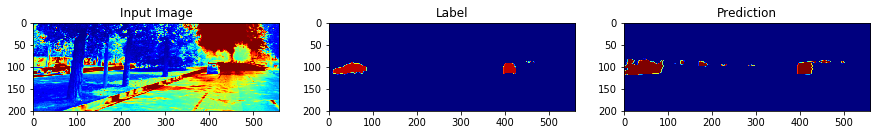

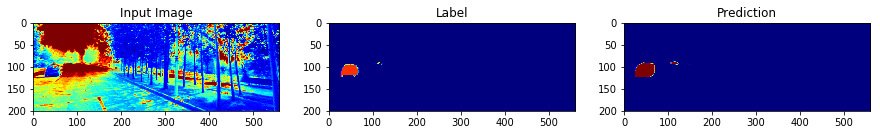

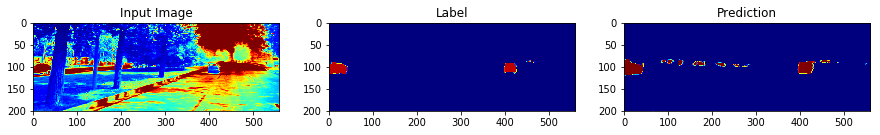

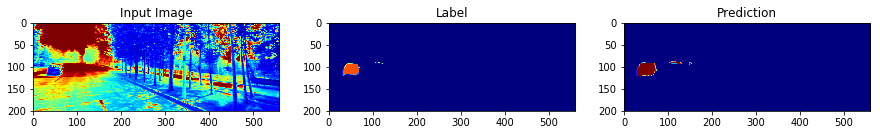

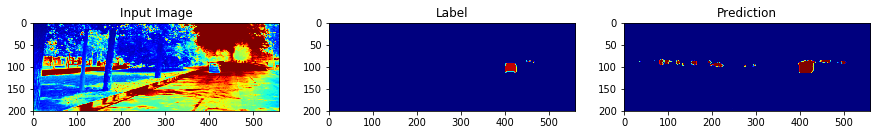

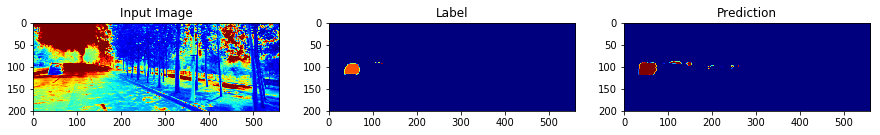

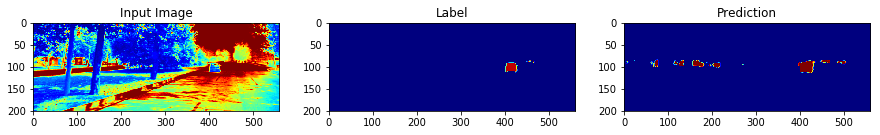

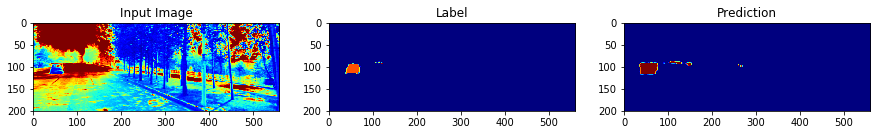

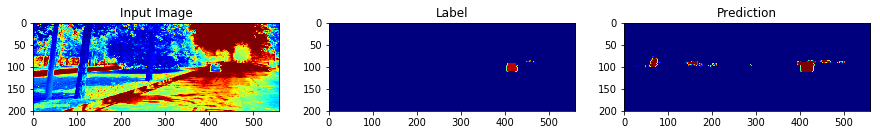

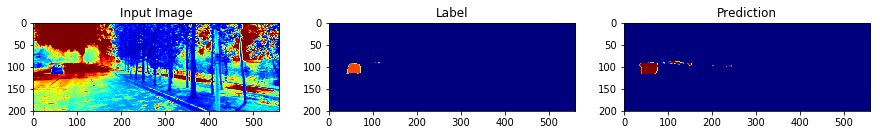

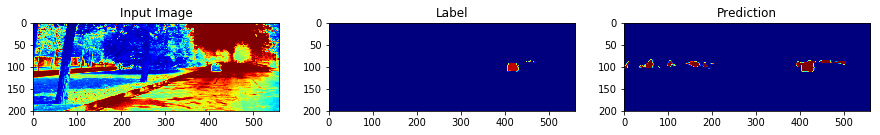

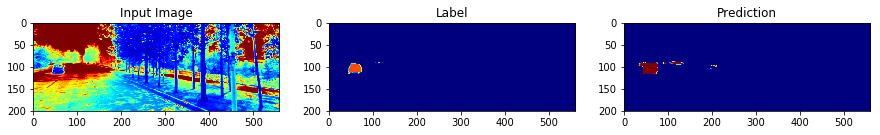

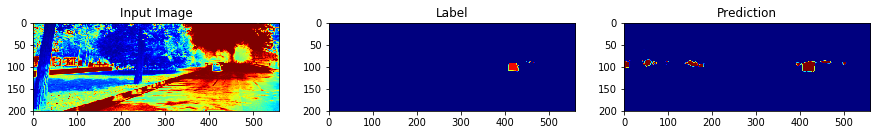

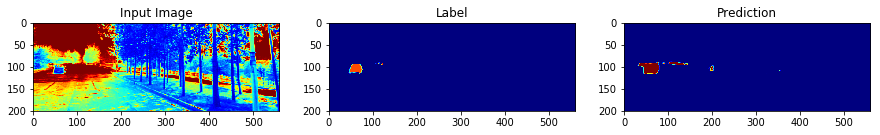

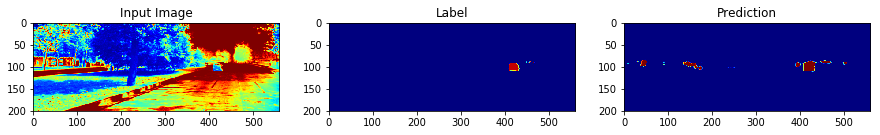

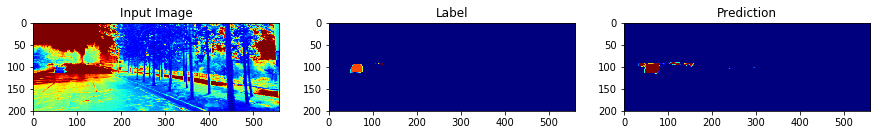

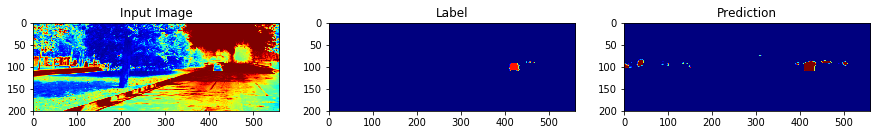

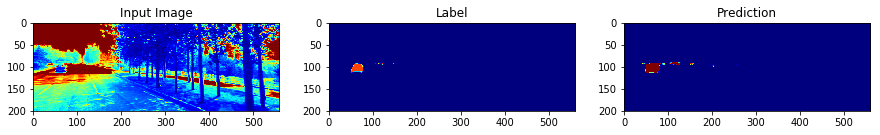

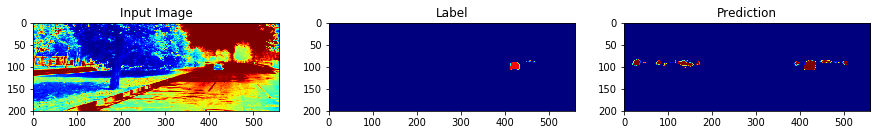

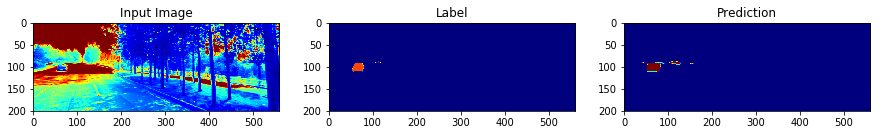

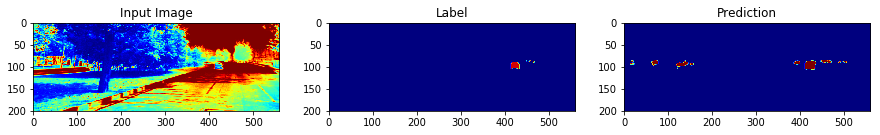

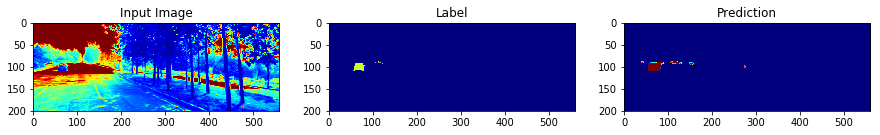

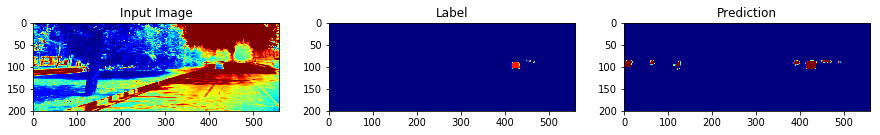

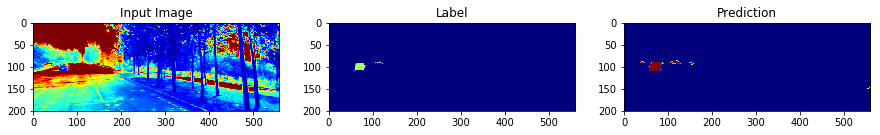

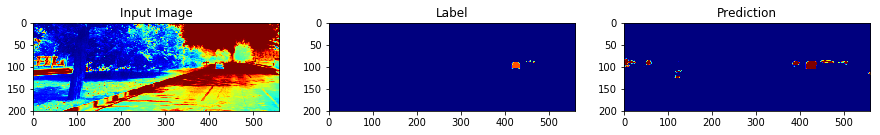

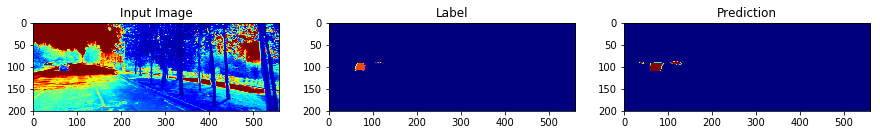

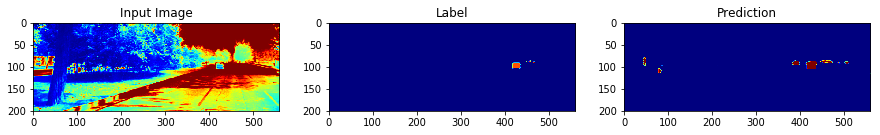

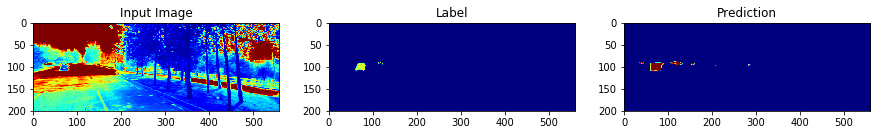

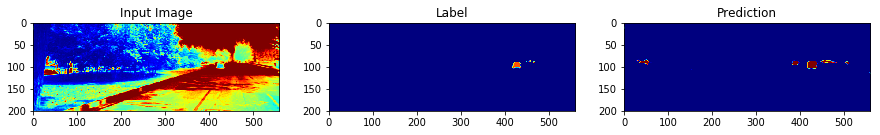

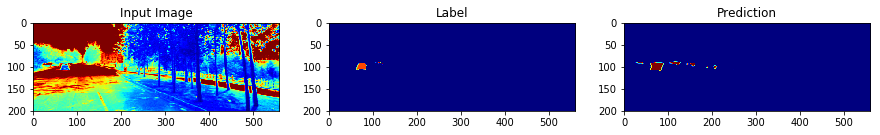

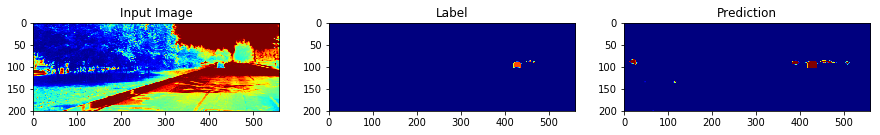

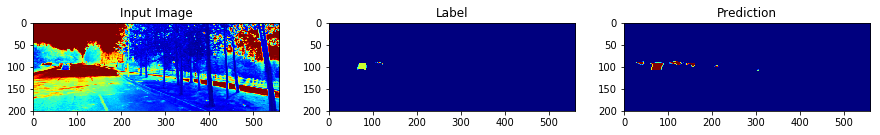

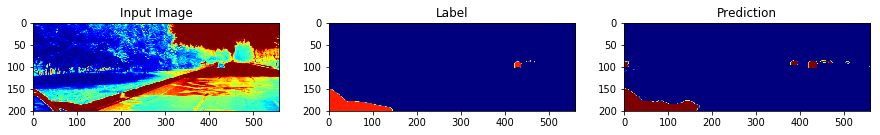

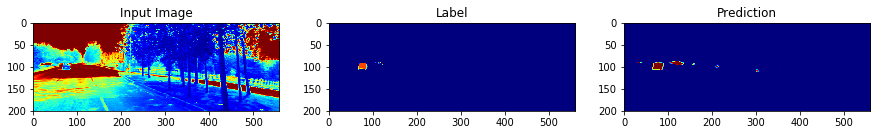

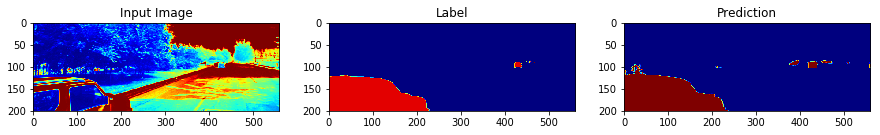

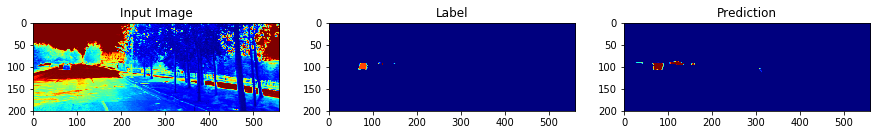

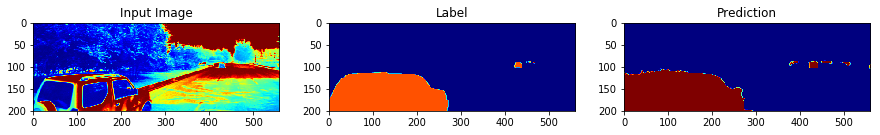

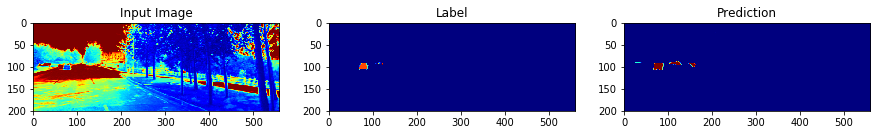

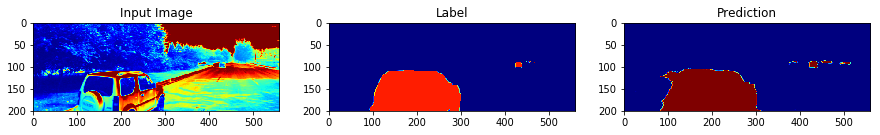

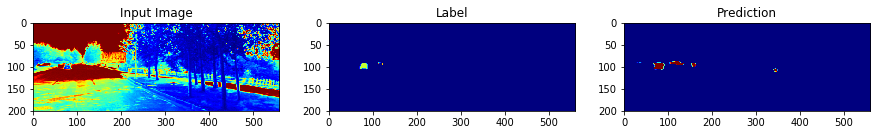

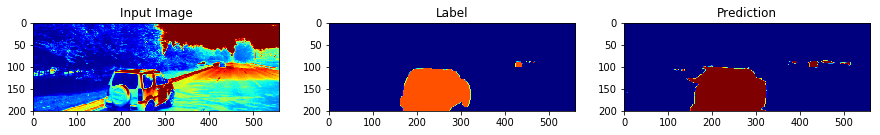

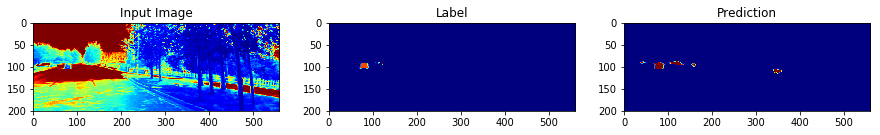

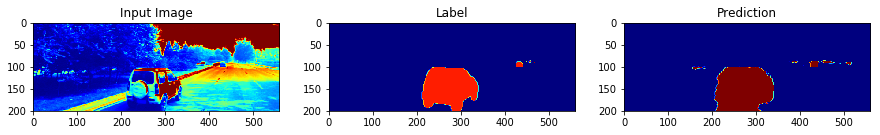

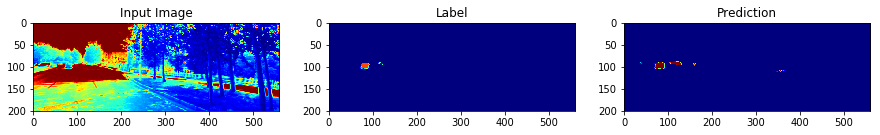

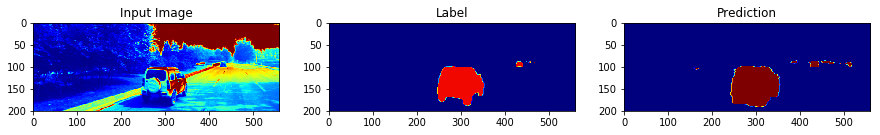

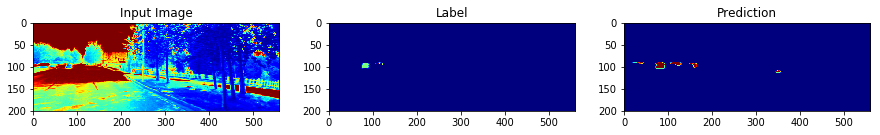

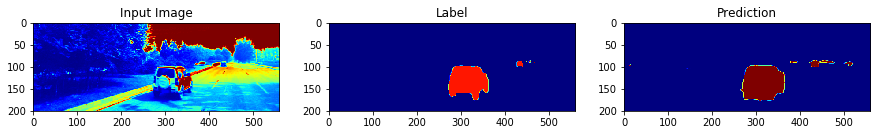

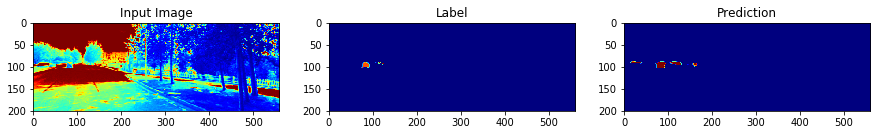

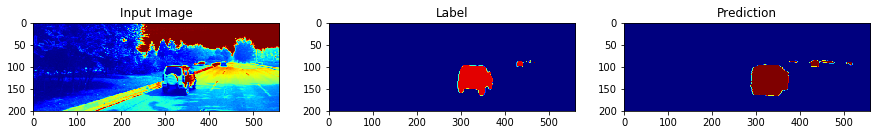

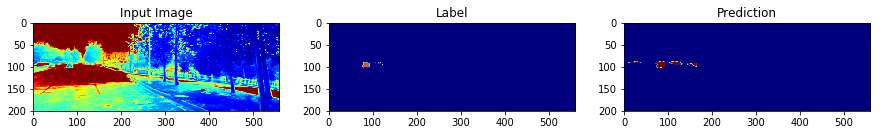

In [39]:
# EVALUATE
# Load Weights
model.load_weights('model-tgs-salt-dice-15-10-2018.h5')

# Evaluate the Model on Random Images
for i in range(100,150):
    # Predict
    original_image = x_valid[i]
    label_image = y_valid[i]
    start_time = time.time()
    prediction_image = model.predict(np.expand_dims(original_image, 0))[0]
    end_time = time.time()
    print('Computation Time:', end_time - start_time)
    
    # Plot
    fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize = (15,15))
    original_image = resize(original_image, (200, 560), anti_aliasing=True)
    label_image = resize(label_image, (200, 560), anti_aliasing=True)
    prediction_image = resize(prediction_image, (200, 560), anti_aliasing=True)
    axis1.imshow(original_image[:,:,0], cmap = 'jet')
    axis1.set_title('Input Image')
    axis2.imshow(label_image[:,:,0], cmap = 'jet')
    axis2.set_title('Label')
    axis3.imshow(prediction_image[:,:,0], cmap = 'jet')
    axis3.set_title('Prediction')